INICIO DEL MODELADO DEL CANAL RUIDOSO

In [2]:
#Importa las librerias
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
import komm

  Using cached komm-0.9.1.tar.gz (83 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
  Created wheel for komm: filename=komm-0.9.1-py3-none-any.whl size=123679 sha256=763d59cee330d0a303b712a55a66f49522f210910170289303011d69dd2f63c1
  Stored in directory: c:\users\alebl\appdata\local\pip\cache\wheels\0b\e1\b1\270012cdd5a7a1f370d8e1ffd5a10a1023c5e700b80755bdec
Successfully built komm
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


Obtención de datos de un archivo .txt

In [4]:
#Obtiene los datos del txt
binario = lambda x, n: format(x, 'b').zfill(n)    #cambia el nivel a binario 
with open("datacod15.txt", "r") as f:
    datos = [line[:-1] for line in f]

Binarios a decimal

In [5]:
#Covertidor
def ConvDec(Datos):
    datos_decimales=[]
    for Dnum in range(1,len(datos)):
        dato_filtrado=datos[Dnum].replace(" ","")  #lee el txt delimitado para evitar errores
        datos_decimales.append(int(dato_filtrado,2))
    return datos_decimales

Crea el canal ruidoso con la biblioteca Komm

In [6]:
#Creación del canal con ruido AWGN
def canal_ruidoso(SNR_dB,Entrada):
    snr_lineal=10**(SNR_dB/10) #Convierte el RUIDO a Lineal
    canal_awgn=komm.AWGNChannel(snr=snr_lineal,signal_power=1.5) #genera el ruido
    syr=canal_awgn(Entrada)       #Se añade ruido a la señal original
    
    
    #Determina la capacidad del canal en base a la hoja de datos del nRF52832
    tasa_datos=2  ##Datarate en Mb/s
    num_simbolos=2      ##Numero de simbolos
    ancho_banda=tasa_datos/(2*np.log2(num_simbolos)) #Ancho de banda 
    capacidad_canal=2*ancho_banda*canal_awgn.capacity()   #Usa una funcion interna para determinar la capacidad


    C_redondeada=round(capacidad_canal,3) #Redondea a 3 decimales
    print('Capacidad del canal es:',C_redondeada,'Mb/s')
    
    
    
    #Prueba la saturacion del canal
    if tasa_datos>=capacidad_canal:
        print("\nEl canal se encuentra saturado\n")
    else:
        print("\nNo se satura el canal\n")
    return syr

Función que guarda el canal con ruido.

In [7]:
def procesar_datos(Data,TamCode):
    np.savetxt("Canalconruido.txt", [int(TamCode)], fmt='%u', delimiter=' ') #Crea el archivo .txt
    codigo_ruido=[int(TamCode)]
    for decdato in Data:
        Nneg=max(0,decdato) #elimina los numeros negativos 
        Nmax=min(Nneg,((2**int(TamCode))-1)) ##Elimina los numeros no respresentables en el tamaño del codigo
        BinRuido=binario(Nmax,int(TamCode))  #Convierte de decimal a binaria 
        ProcCode=np.round(np.array(list(BinRuido),dtype=np.float32)).astype(int)  #Procesa el resultado binario 
        with open("Canalconruido.txt","a") as f:             #Guarda datos en el txt
            np.savetxt(f, [ProcCode], fmt='%1.0u', delimiter=' ')
        codigo_ruido.append(ProcCode) #Agrega el dato a la lista 
    return codigo_ruido

Declaración del conjunto de datos y el SNR utilizado

In [8]:
periodo_prueba = np.arange(0.01, 5.0, 0.01)  #periodo a probar
señal_senoidal = np.sin(2 * np.pi * periodo_prueba)      #Senoidal a probar

datos_codificados=ConvDec(datos)   #Crea el conjunto de datos ya convertidos a decimal
SNR_dB=1                         #Declara el SNR a utilizar

Bloque principal del canal, aquí realiza el llamado a todas las funciones

Capacidad del canal es: 1.176 Mb/s

El canal se encuentra saturado

Capacidad del canal es: 1.176 Mb/s

El canal se encuentra saturado



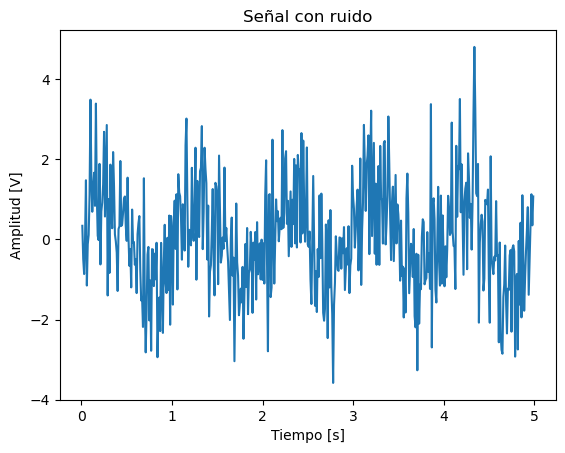

In [9]:
def EjecucionCanal(Datos,SNR_dB):                    #Función  principal del bloque del canal                                            
    CanalRuido=canal_ruidoso(SNR_dB,Datos)            #Creación del canal ruidoso utilizando la función CANAL AWGN
    SenalRuidoRedondeada=np.round(CanalRuido).astype(int)    #Redondea la senal ruidosa (array) a un int
    datasave=procesar_datos(SenalRuidoRedondeada,datos[0])   #Guarda la señal ruidosa en bits
    
    return SenalRuidoRedondeada

RuidoP=canal_ruidoso(SNR_dB,señal_senoidal) 
RuidoS=EjecucionCanal(datos_codificados,SNR_dB)   #Llama la función principal del canal

#Visualización de la señal con ruido.
#pltime=1200
sr=plt.figure()
sruidos=plt.plot(periodo_prueba,RuidoP)
plt.title("Señal con ruido")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]")
plt.show()
sr.clear()

VIsualización de los datos

El dato enviado por el transmisor es  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]


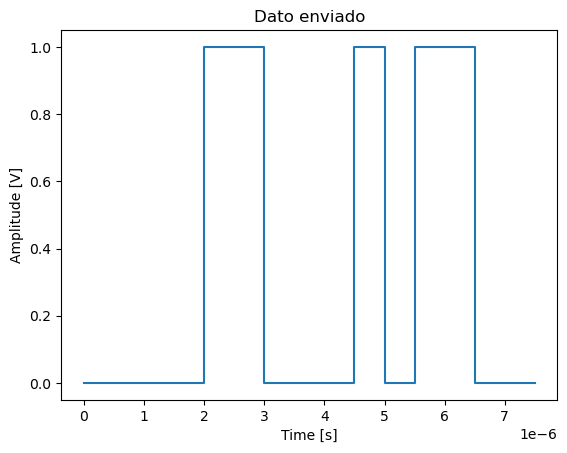

In [10]:
#Visualización del dato de entrada
Endatos=list(map(int,list(datos[15].split())))
T_SoC=1/(2*10**6)
Endatos.insert(0,Endatos[0])   #Sin ruido

Time_data=np.linspace(0,(len(Endatos)-1)*T_SoC,len(Endatos))  ##Eje basado en el tiempo de la hoja de datos

print("El dato enviado por el transmisor es ",list(Endatos)) #Dato recibido
recibido=plt.figure()
plotConRuido=plt.step(Time_data,Endatos)
plt.title("Dato enviado")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.show()
recibido.clear()

Visualización del dato transmitido (Ruido)

El dato que llega al receptor es:  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]


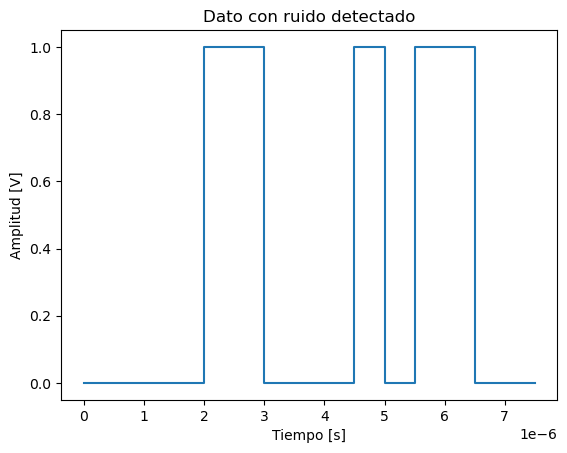

In [11]:
#Lectura del dato con ruido guardado en un txt
with open("Canalconruido.txt", "r") as f:
    DatosRuido = [line[:-1] for line in f]

#Impresión del dato recibido
DR1=list(map(int,list(DatosRuido[15].split())))
DR1.insert(0,DR1[0])
print("El dato que llega al receptor es: ",DR1)    
#Gráfica del dato ruidoso
f1=plt.figure()
GraficoConRuido=plt.step(Time_data,DR1)
plt.title("Dato con ruido detectado")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]")
plt.show()
f1.clear()